# Gousto Recipe Rank Forecasting: MSc Project

### Import Modules and Load Dataset

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import os
import json

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import time

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb


In [76]:
directory = os.getcwd()
file_path = os.path.join(directory, '..', 'data', 'extended_training_df_619.json')

# Read JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

fields = [field['name'] for field in data['schema']['fields'] if field['name'] != 'index']
records = data.get('data', [])

# Convert the records to a DataFrame
df = pd.DataFrame(records, columns=fields)
df['item_id'] = pd.to_numeric(df['item_id'], errors='coerce')
df.drop(columns=['contamination_outlier', 'uptake_at_lead_day_-6'], inplace=True)

In [77]:
df['recipe_rank'] = df.groupby('menu_week')['recipe_uptake'].rank(method='first', ascending=False) - 1
df['recipe_rank'] = df['recipe_rank'].astype(int)

columns_to_rank = [f'uptake_at_lead_day_{j}' for j in range(-5, 19)]
for i, col in enumerate(columns_to_rank):
    df[col] = df.groupby('menu_week')[col].rank(method='first', pct=True, ascending=True)
    if i > 0:
        prev_col = columns_to_rank[i-1]  # Previous column
        df[f'diff_uptake_at_lead_day_{i-6}'] = df[prev_col] - df[col]

df_live = df.copy()
df_live = df_live[df_live['menu_week'] >= 488]

columns_to_remove = df.filter(like="uptake_at_lead_day").columns
df.drop(columns=columns_to_remove, inplace=True)

# Drop helper columns
df = df.drop(columns=['recipe_uptake'])
df_live = df_live.drop(columns=['recipe_uptake'])

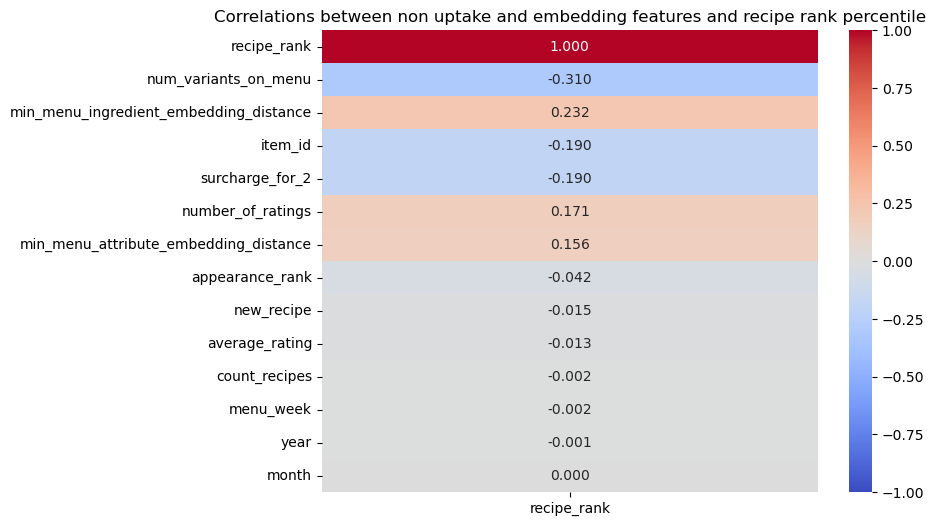

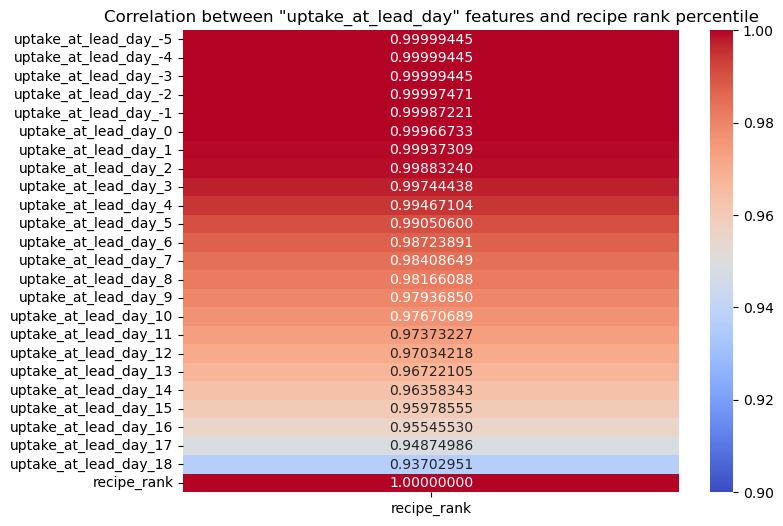

In [78]:
# Rank recipe_rank within each menu_week
df_live_pct = df_live.copy()
df_live_pct['recipe_rank'] = df_live_pct.groupby('menu_week')['recipe_rank'].rank(method='first', pct=True, ascending=False)

# Drop uptake_at_lead_day and recipe_rank columns, and compute correlation with the target
non_uptake_features = df_live_pct.drop(columns=df_live_pct.filter(regex='uptake_at_lead_day|embeddings').columns)
non_uptake_features = non_uptake_features.drop(columns=['recipe_rank'])
non_uptake_corr = pd.concat([non_uptake_features, df_live_pct['recipe_rank']], axis=1).corr()

# Sort features by absolute correlation and select top 20
sorted_corr = non_uptake_corr[['recipe_rank']].dropna().reindex(non_uptake_corr[['recipe_rank']].dropna().apply(lambda x: abs(x)).sort_values(by='recipe_rank', ascending=False).index)

# Plot the top 20 most correlated features
plt.figure(figsize=(8, 6))
sns.heatmap(sorted_corr, annot=True, fmt='.3f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Correlations between non uptake and embedding features and recipe rank percentile')
plt.show()

# Calculate correlation for uptake_at_lead_day features
uptake_features = df_live.filter(regex=r'^uptake_at_lead_day')
uptake_corr = pd.concat([uptake_features, df_live_pct['recipe_rank']], axis=1).corr()

# Plot correlation for uptake_at_lead_day features
plt.figure(figsize=(8, 6))
sns.heatmap(uptake_corr[['recipe_rank']].dropna(), annot=True, fmt='.8f', cmap='coolwarm', vmin=0.90, vmax=1)
plt.title('Correlation between "uptake_at_lead_day" features and recipe rank percentile')
plt.show()

### Functions for Data Normalisation and Custom Time Series Cross Validation

In [79]:
# Function to normalise data
def normalize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrame to maintain the index
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
    
    return X_train_scaled, X_test_scaled

# Function for custom time series cross validation split, for the final 3 menu weeks
def custom_time_series_cv(X_train, n_validation_weeks=3):
    validation_weeks = X_train['menu_week'].unique()[-n_validation_weeks:]
    for valid_week in validation_weeks:
        train_df = X_train[X_train['menu_week'] < valid_week]
        valid_df = X_train[X_train['menu_week'] == valid_week]
        yield train_df.index, valid_df.index

### Function to evaluate predictions and plot error bars

In [80]:
def evaluate_predictions_live(all_errors, feature_errors, method, days_before_target=18, total_week_iterations=20):
    average_errors = []
    error_sems = []  # To store 2 * standard errors for model predictions (95% CI)
    feature_maes = []  # To store average feature MAE
    feature_mae_sems = []  # To store 2 * standard errors for feature MAE (95% CI)

    for i in range(days_before_target + 7):
        errors_for_week = [iteration[i]['mean_absolute_error'] for iteration in all_errors if i < len(iteration)]
        average_error = np.mean(errors_for_week)
        error_sem = (np.std(errors_for_week) / np.sqrt(len(errors_for_week))) * 2  # 2 * standard error for 95% CI
        average_errors.append({'days_before': days_before_target - i, 'average_mean_absolute_error': average_error})
        error_sems.append({'days_before': days_before_target - i, 'error_sem': error_sem})

        # Process feature MAE
        feature_maes_for_week = [iteration[i]['feature_mae'] for iteration in feature_errors if i < len(iteration)]
        if feature_maes_for_week:
            feature_avg_mae = np.mean(feature_maes_for_week)
            feature_sem = (np.std(feature_maes_for_week) / np.sqrt(len(feature_maes_for_week))) * 2  # 2 * standard error for 95% CI
            feature_maes.append({'days_before': days_before_target - i, 'feature_mean_absolute_error': feature_avg_mae})
            feature_mae_sems.append({'days_before': days_before_target - i, 'feature_sem': feature_sem})

    average_errors_df = pd.DataFrame(average_errors)
    error_sems_df = pd.DataFrame(error_sems)
    feature_maes_df = pd.DataFrame(feature_maes)
    feature_mae_sems_df = pd.DataFrame(feature_mae_sems)

    # Create the plot with specified colors and enhancements
    plt.figure(figsize=(12, 6))

    # Plot for feature uptake_at_lead_day MAE with 95% CI error bars (2 * standard errors)
    plt.errorbar(feature_maes_df['days_before'], feature_maes_df['feature_mean_absolute_error'], 
                 yerr=feature_mae_sems_df['feature_sem'], fmt='--s', capsize=5, 
                 color='orange', ecolor='red', elinewidth=2, markerfacecolor='orange', label=f'Uptake Feature MAE (95% CI)')
    
    # Plot for model predictions with 95% CI error bars (2 * standard errors)
    plt.errorbar(average_errors_df['days_before'], average_errors_df['average_mean_absolute_error'], 
                 yerr=error_sems_df['error_sem'], fmt='-o', capsize=5, 
                 color='purple', ecolor='blue', elinewidth=2, markerfacecolor='purple', label='Predicted MAE (95% CI)')
    
    plt.ylim(-0.005, 0.165)
    plt.yticks(np.arange(0, 0.17, 0.01))
    plt.xticks(np.arange(days_before_target, -7, -1))
    plt.xlim(-7, days_before_target+1)
    plt.xlabel('Days Before Target')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'{method}: Average Mean Absolute Error over {days_before_target} Days Before Target Across {total_week_iterations} Iterations')
    plt.gca().invert_xaxis()
    plt.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.4)
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    plt.grid(True)
    plt.legend()
    plt.show()


In [81]:
def get_linear_regression_predictions(X_train, y_train, X_test):
    X_train, X_test = normalize_data(X_train, X_test)
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    predictions = lr_model.predict(X_test)
    return pd.Series(predictions, index=X_test.index)

#XGBoost
def get_xgboost_predictions(X_train, y_train, X_test):
    params = {
        'objective': 'reg:logistic',
        'eval_metric': 'mae',
        'max_depth': 6,
    }
    model_xgboost = xgb.XGBRegressor(**params)
    model_xgboost.fit(X_train, y_train)
    predictions = model_xgboost.predict(X_test)
    return pd.Series(predictions, index=X_test.index)

#LightGBM
def get_lightgbm_predictions(X_train, y_train, X_test):
    params = {
        'verbose': -1,
        'objective': 'regression',
        'metric': 'mae',
        'max_depth': 6,
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return pd.Series(predictions, index=X_test.index)

In [82]:
def get_random_forest_predictions(X_train, y_train, X_test):
    params = {
        'n_estimators': 100,
        'max_depth': 6,
        'criterion': 'friedman_mse',
        'random_state': 42,
        'n_jobs': -1,
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return pd.Series(predictions, index=X_test.index)

# Lambdarank
def get_lgbm_ranker_predictions(X_train, y_train, X_test):
    group_train = X_train.groupby('menu_week').size().to_list() 
    params = {
        'objective': 'lambdarank',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'importance_type': 'split',
        'label_gain': list(range(max(group_train))),
        'verbose': -1,
        'n_jobs': -1,
        'random_state': 42,
    }
    model = lgb.LGBMRanker(**params)
    model.fit(X_train, y_train, group=group_train)
    predictions = model.predict(X_test)
    return pd.Series(predictions, index=X_test.index)

def get_xgboost_ranker_predictions(X_train, y_train, X_test):
    group_train = X_train.groupby('menu_week').size().to_list() 
    params = {
        'objective': 'rank:ndcg',
        'eval_metric': 'ndcg',
        'learning_rate': 0.15,
        'max_depth': 6,
        'min_child_weight': 17,
        'gamma': 1.0,
        'lambda': 0.01,
        'alpha': 0.2,
        'random_state': 42,
        'n_jobs': -1,
        'ndcg_exp_gain': False,  # Disable exponential gain for NDCG
        'random_state': 42,
    }

    num_boost_round = 100  # This replaces the 'n_estimators' parameter

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtrain.set_group(group_train)

    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    dtest = xgb.DMatrix(X_test)
    predictions = model.predict(dtest)
    return pd.Series(predictions, index=X_test.index)

def get_catboost_ranker_predictions(X_train, y_train, X_test):
    group_train = X_train['menu_week']
    params = {
        'learning_rate': 0.3,
        'iterations': 50,
        'loss_function': 'PairLogit',
        'verbose': False,
        'random_seed': 42,
        'bootstrap_type': 'Bernoulli',
        'eval_metric': 'NDCG',
        'random_seed': 42,
    }
    model = cb.CatBoostRanker(**params)
    model.fit(X_train, y_train, group_id=group_train)
    predictions = model.predict(X_test)
    return pd.Series(predictions, index=X_test.index)

In [83]:
# Function to run evaluation given algorithm
def run_evaluation_live(df, target_week_range, days_before_target=18, method='linear_regression'):
    df = df.copy()

    total_week_iterations = len(target_week_range)
    all_errors = []
    feature_errors = []
    num_models = 0
    total_models = total_week_iterations * (days_before_target + 7)

    method_dict = {
    'linear_regression': get_linear_regression_predictions,
    'xgboost': get_xgboost_predictions,
    'lightgbm': get_lightgbm_predictions,
    'random_forest': get_random_forest_predictions,
    'lgbm_ranker': get_lgbm_ranker_predictions,
    'xgboost_ranker': get_xgboost_ranker_predictions,
    'catboost_ranker': get_catboost_ranker_predictions,
    }

    
    if method not in method_dict:
        raise ValueError("Invalid method specified.")

    if (method != 'lgbm_ranker'):
        df['recipe_rank'] = df.groupby('menu_week')['recipe_rank'].rank(method='first', pct=True, ascending=False)
    

    for target_week in target_week_range:
        iteration_errors = []
        feature_iteration_errors = []
        elapsed_times = []
        for days_before in range(0, days_before_target + 7):
            start_time = time.time()
            num_models += 1
            # Add the uptake_at_lead_day column for the current days_before
            columns_to_keep = [f'uptake_at_lead_day_{days_before_target + 1 - days_before}']
            for i in range(0, days_before + 1):
                columns_to_keep.append(f'diff_uptake_at_lead_day_{days_before_target + 1 - i}')
                
            # columns_to_keep = [f'uptake_at_lead_day_{days_before_target + 1 - days_before}', f'diff_uptake_at_lead_day_{days_before_target + 1 - days_before}']
            columns_to_remove = [col for col in df.columns if 'uptake_at_lead_day_' in col and col not in columns_to_keep]
            df_reduced = df.drop(columns=columns_to_remove)
            # columns = df_reduced.filter(like="uptake_at_lead_day").columns

            buffer = (max(0, days_before_target + 1 - days_before) // 7) + 1

            train_df = df_reduced[df_reduced['menu_week'] <= target_week - buffer]
            test_df = df_reduced[df_reduced['menu_week'] == target_week]

            X_train = train_df.drop(columns=['recipe_rank'])
            y_train = train_df['recipe_rank']

            X_test = test_df.drop(columns=['recipe_rank'])
            y_test = test_df['recipe_rank']

            y_pred_values = method_dict[method](X_train, y_train, X_test)
            y_pred_values = pd.Series(y_pred_values).rank(ascending=True, pct=True, method='first').to_numpy()
            if (method == 'lgbm_ranker'):
                y_test = pd.Series(y_test).rank(ascending=False, pct=True, method='first')
                y_pred_values = 1 - y_pred_values
            mean_absolute_error_value = mean_absolute_error(y_test.values, y_pred_values)
            iteration_errors.append({'days_before': days_before_target - days_before, 'mean_absolute_error': mean_absolute_error_value})

            uptake_feature_col = f'uptake_at_lead_day_{days_before_target + 1 - days_before}'
            if uptake_feature_col in X_test.columns:
                y_feature_test = X_test[uptake_feature_col].values
                feature_mae_value = mean_absolute_error(y_test, y_feature_test)
                feature_iteration_errors.append({'days_before': days_before_target - days_before, 'feature_mae': feature_mae_value})
            else:
                feature_iteration_errors.append({'days_before': days_before_target - days_before, 'feature_mae': mean_absolute_error_value})
                
            time_elapsed = time.time() - start_time
            elapsed_times.append(time_elapsed)
            if len(elapsed_times) > 20:
                elapsed_times.pop(0)

            if elapsed_times:
                avg_time_elapsed = sum(elapsed_times) / len(elapsed_times)
                minutes, seconds = divmod(avg_time_elapsed * (total_models - num_models), 60)

            print(f"No. of models progress: {num_models}/{total_models} | Estimated Time Left: {int(minutes)} minutes and {int(seconds)} seconds              ", end='\r')

        all_errors.append(iteration_errors)
        feature_errors.append(feature_iteration_errors)
        
    evaluate_predictions_live(all_errors, feature_errors, method, days_before_target, total_week_iterations)
    return all_errors, feature_errors

In [84]:
def run_evaluation_live(df, target_week_range, days_before_target=18, method='linear_regression'):
    df = df.copy()

    total_week_iterations = len(target_week_range)
    all_errors = []
    feature_errors = []
    num_models = 0
    total_models = total_week_iterations * (days_before_target + 7)

    method_dict = {
    'linear_regression': get_linear_regression_predictions,
    'xgboost': get_xgboost_predictions,
    'lightgbm': get_lightgbm_predictions,
    'random_forest': get_random_forest_predictions,
    'lgbm_ranker': get_lgbm_ranker_predictions,
    'xgboost_ranker': get_xgboost_ranker_predictions,
    'catboost_ranker': get_catboost_ranker_predictions,
    }

    if method not in method_dict:
        raise ValueError("Invalid method specified.")

    if (method != 'lgbm_ranker'):
        df['recipe_rank'] = df.groupby('menu_week')['recipe_rank'].rank(method='first', pct=True, ascending=False)

    # Temporary dictionary to store predictions for each target week and day before
    predictions_dict = {}

    for target_week in target_week_range:
        iteration_errors = []
        feature_iteration_errors = []
        elapsed_times = []
        for days_before in range(0, days_before_target + 7):
            start_time = time.time()
            num_models += 1
            # Add the uptake_at_lead_day column for the current days_before
            columns_to_keep = [f'uptake_at_lead_day_{days_before_target + 1 - days_before}']
            for i in range(0, days_before + 1):
                columns_to_keep.append(f'diff_uptake_at_lead_day_{days_before_target + 1 - i}')
                
            columns_to_remove = [col for col in df.columns if 'uptake_at_lead_day_' in col and col not in columns_to_keep]
            df_reduced = df.drop(columns=columns_to_remove)

            buffer = (max(0, days_before_target + 1 - days_before) // 7) + 1

            train_df = df_reduced[df_reduced['menu_week'] <= target_week - buffer]
            test_df = df_reduced[df_reduced['menu_week'] == target_week]

            X_train = train_df.drop(columns=['recipe_rank'])
            y_train = train_df['recipe_rank']

            X_test = test_df.drop(columns=['recipe_rank'])
            y_test = test_df['recipe_rank']

            y_pred_values = method_dict[method](X_train, y_train, X_test)
            y_pred_values = pd.Series(y_pred_values).rank(ascending=True, pct=True, method='first').to_numpy()
            if (method == 'lgbm_ranker'):
                y_test = pd.Series(y_test).rank(ascending=False, pct=True, method='first')
                y_pred_values = 1 - y_pred_values
            mean_absolute_error_value = mean_absolute_error(y_test.values, y_pred_values)
            iteration_errors.append({'days_before': days_before_target - days_before, 'mean_absolute_error': mean_absolute_error_value})

            uptake_feature_col = f'uptake_at_lead_day_{days_before_target + 1 - days_before}'
            if uptake_feature_col in X_test.columns:
                y_feature_test = X_test[uptake_feature_col].values
                feature_mae_value = mean_absolute_error(y_test, y_feature_test)
                feature_iteration_errors.append({'days_before': days_before_target - days_before, 'feature_mae': feature_mae_value})
            else:
                feature_iteration_errors.append({'days_before': days_before_target - days_before, 'feature_mae': mean_absolute_error_value})

            # Save predictions temporarily in the dictionary
            pred_col_name = f'pred_at_lead_day_{days_before_target + 1 - days_before}'
            predictions_dict[(target_week, pred_col_name)] = y_pred_values

            time_elapsed = time.time() - start_time
            elapsed_times.append(time_elapsed)
            if len(elapsed_times) > 20:
                elapsed_times.pop(0)

            if elapsed_times:
                avg_time_elapsed = sum(elapsed_times) / len(elapsed_times)
                minutes, seconds = divmod(avg_time_elapsed * (total_models - num_models), 60)

            print(f"No. of models progress: {num_models}/{total_models} | Estimated Time Left: {int(minutes)} minutes and {int(seconds)} seconds              ", end='\r')

        all_errors.append(iteration_errors)
        feature_errors.append(feature_iteration_errors)
    
    # Append all predictions to the dataframe after all evaluations are done
    for (target_week, pred_col_name), predictions in predictions_dict.items():
        df.loc[df['menu_week'] == target_week, pred_col_name] = predictions

    evaluate_predictions_live(all_errors, feature_errors, method, days_before_target, total_week_iterations)
    
    # Return the modified dataframe with prediction columns
    return df

### Execute Code

In [86]:
setback = 127
original_max_week = df['menu_week'].max() + 1 - setback

# Run the evaluation
total_week_iterations = 4
days_before_target = 18
target_week_range = range(original_max_week - total_week_iterations, original_max_week)

# print("Linear Regression:"); run_evaluation_live(df_live, target_week_range, days_before_target, method='linear_regression')

# print("LightGBM:"); run_evaluation_live(df_live, target_week_range, days_before_target, method='lightgbm')

# print("XGBoost:"); run_evaluation_live(df_live, target_week_range, days_before_target, method='xgboost')

# print("Random Forest:"); run_evaluation_live(df_live, target_week_range, days_before_target, method='random_forest')

# print("LightGBM Ranker:") ; run_evaluation_live(df_live, target_week_range, days_before_target, method='lgbm_ranker')

# print("XGBoost Ranker:") ; run_evaluation_live(df_live, target_week_range, days_before_target, method='xgboost_ranker')

# print("CatBoost Ranker:") ; run_evaluation_live(df_live, target_week_range, days_before_target, method='catboost_ranker')


df_preds = run_evaluation_live(df_live, target_week_range, days_before_target, method='lightgbm')
# df_preds = df_preds.fillna(0)

ValueError: Input data must be 2 dimensional and non empty.

In [74]:
df_preds_2 = df_preds[df_preds['menu_week']>= 491]
display(df_preds_2[['menu_week', 'uptake_at_lead_day_-5', 'recipe_rank', 'pred_at_lead_day_19', 'pred_at_lead_day_18', 'pred_at_lead_day_17', 'pred_at_lead_day_0', 'pred_at_lead_day_-5']])

,menu_week,uptake_at_lead_day_-5,recipe_rank,pred_at_lead_day_19,pred_at_lead_day_18,pred_at_lead_day_17,pred_at_lead_day_0,pred_at_lead_day_-5
12685,491,0.908046,0.908046,0.862069,0.804598,0.839080,0.908046,0.908046
12686,491,0.839080,0.839080,0.540230,0.908046,0.919540,0.827586,0.839080
12687,491,0.942529,0.942529,0.988506,0.988506,0.988506,0.931034,0.931034
12688,491,0.931034,0.931034,0.885057,0.942529,0.954023,0.919540,0.954023
12689,491,0.586207,0.586207,0.459770,0.620690,0.609195,0.597701,0.586207
...,...,...,...,...,...,...,...,...
27325,619,0.912000,0.912000,0.760000,0.960000,0.944000,0.912000,0.912000
27326,619,0.248000,0.248000,0.248000,0.256000,0.216000,0.240000,0.248000
27327,619,0.728000,0.728000,0.624000,0.872000,0.856000,0.728000,0.728000
27328,619,0.664000,0.664000,0.840000,0.768000,0.744000,0.664000,0.664000


In [87]:
df_preds_2.to_csv('df_preds_lgbm.csv', index=False)

In [ ]:
def calculate_avg_mae(df, days_before_target=21):
    df = df.copy()
    # Dictionary to store MAEs for each lead day
    maes = {}

    # Loop over each lead day from 18 to -6 (days_before_target + 1 to -6)
    for days_before in range(days_before_target + 1, -6, -1):
        # Construct the column names for the actual and predicted values
        actual_col = f'recipe_rank'
        pred_col = f'pred_at_lead_day_{days_before}'

        # Check if both columns exist in the dataframe
        if actual_col in df.columns and pred_col in df.columns:
            # Filter the non-null rows (to avoid calculation errors)
            non_null_rows = df[[actual_col, pred_col]].dropna()

            # Calculate MAE for this lead day
            mae = mean_absolute_error(non_null_rows[actual_col], non_null_rows[pred_col])

            # Store the result in the dictionary
            maes[days_before] = mae

    # Print the average MAEs for each lead day
    print("Average MAEs for each lead day:")
    for days_before, mae in maes.items():
        print(f"Lead Day {days_before-1}: {mae:.4f}")

# Example usage with your dataframe
calculate_avg_mae(df_preds_2, days_before_target=21)